In [3]:
import numpy as np
from torchmetrics.classification import MulticlassF1Score, ConfusionMatrix, CohenKappa, MulticlassMatthewsCorrCoef
from torch.utils.data import Subset
import tqdm
import torch
from capture24.patch_tst import PatchTST
import yaml
import gzip
from capture24.patch_tst import C24_Dataset
from torch.utils.data import DataLoader
import os
import json

In [4]:
# Files - paths
path_512 = 'patch_512_baselines'
path_1024 = 'patch_1024_baselines'

In [5]:
def get_eval_metrics(model, test_loader, test_length):
    f1_score = MulticlassF1Score(num_classes=10, average='macro')
    f1_score_micro = MulticlassF1Score(num_classes=10, average='micro')
    f1_score_none = MulticlassF1Score(num_classes=10, average=None)
    cm = ConfusionMatrix(num_classes=10, task='multiclass')
    ck = CohenKappa(task = 'multiclass', num_classes=10)
    mcc = MulticlassMatthewsCorrCoef(num_classes=10)

    N = test_length

    for x, y in test_loader:
        outputs = model(x)

        preds = outputs.argmax(dim=1)


        f1_score.update(preds, y)
        f1_score_micro.update(preds, y)
        f1_score_none.update(preds, y)
        cm.update(preds, y)
        ck.update(preds, y)
        mcc.update(preds, y)
    

    # Evaluation Metrics - append to the lists
    final_f1_macro = f1_score.compute()
    final_f1_micro = f1_score_micro.compute()
    final_f1_none = f1_score_none.compute()
    final_ck = ck.compute()
    final_mcc = mcc.compute()

    # Reset the metrics
    f1_score.reset()
    f1_score_micro.reset()
    f1_score_none.reset()
    ck.reset()
    mcc.reset()

    return final_f1_macro, final_f1_micro, final_f1_none, final_ck, final_mcc





In [6]:
def build_model(PATH):
    with open(f'{PATH}/config_1.yaml', 'r') as f:
        config = yaml.safe_load(f)

    model = PatchTST(config)
    model.load_state_dict(torch.load(f'{PATH}/patchtst_model.pth', weights_only=True, map_location=torch.device('cpu')))
    model.eval()
    return model


In [7]:
def build_dataset(PATH):
    with gzip.open(f'{PATH}/X_test.npy.gz', 'rb') as f:
        X_test = np.load(f)
    with gzip.open(f'{PATH}/y_test.npy.gz', 'rb') as f:
        y_test = np.load(f)

    # Load the index to label and label to index
    with open(f'{PATH}/label_to_index.json', 'r') as f:
        data = json.load(f)

    idx_to_label = data['index_to_label']
    label_to_idx = data['label_to_index']

    # Insert into dataset
    test_dataset = C24_Dataset(X_test, y_test, idx_to_label, label_to_idx)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=128, 
        shuffle=False, 
        num_workers=0, 
        pin_memory=False, 
        drop_last=False, 
        persistent_workers=False, 
        prefetch_factor=None,
    )
    return test_loader, len(y_test)

In [11]:
paths = ['patch_512_baselines', 'patch_1024_baselines_experiment_patches/']
folders = ['p16', 'p32', 'p64']

results_512 = {}
results_1024 = {}
for path in paths:
    for folder in folders:
        print(f"Evaluating {path} {folder}")
        PATH = f'{path}/{folder}'
        # dataset will be lookback dependent
        if path == 'patch_512_baselines':
            test_loader, test_length = build_dataset("capture24/final_data_512")
        else:
            test_loader, test_length = build_dataset("capture24/final_data_1024")
        model = build_model(PATH)
        f1_scores_boot, f1_scores_micro_boot, f1_scores_none_boot, ck_boot, mcc_boot = get_eval_metrics(model, test_loader, test_length)
        if path == 'patch_512_baselines':
            results_512[folder] = {
                'f1_scores_boot': f1_scores_boot,
                'f1_scores_micro_boot': f1_scores_micro_boot,
                'f1_scores_none_boot': f1_scores_none_boot,
                'ck_boot': ck_boot,
                'mcc_boot': mcc_boot,
                'patch_size': folder,
                'lookback_window': 512
            }
        else:   
            results_1024[folder] = {
                'f1_scores_boot': f1_scores_boot,
                'f1_scores_micro_boot': f1_scores_micro_boot,
                'f1_scores_none_boot': f1_scores_none_boot,
                'ck_boot': ck_boot,
                'mcc_boot': mcc_boot,
                'patch_size': folder,
                'lookback_window': 1024
            }

results_512
results_1024


Evaluating patch_512_baselines p16
Evaluating patch_512_baselines p32
Evaluating patch_512_baselines p64
Evaluating patch_1024_baselines_experiment_patches/ p16
Evaluating patch_1024_baselines_experiment_patches/ p32
Evaluating patch_1024_baselines_experiment_patches/ p64


{'p16': {'f1_scores_boot': tensor(0.3779),
  'f1_scores_micro_boot': tensor(0.6936),
  'f1_scores_none_boot': tensor([0.6869, 0.3929, 0.0035, 0.1558, 0.7406, 0.9123, 0.0526, 0.0242, 0.4198,
          0.3902]),
  'ck_boot': tensor(0.5722),
  'mcc_boot': tensor(0.5772),
  'patch_size': 'p16',
  'lookback_window': 1024},
 'p32': {'f1_scores_boot': tensor(0.3820),
  'f1_scores_micro_boot': tensor(0.6946),
  'f1_scores_none_boot': tensor([0.6928, 0.4079, 0.0031, 0.1639, 0.7452, 0.9107, 0.0677, 0.0295, 0.4028,
          0.3965]),
  'ck_boot': tensor(0.5750),
  'mcc_boot': tensor(0.5796),
  'patch_size': 'p32',
  'lookback_window': 1024},
 'p64': {'f1_scores_boot': tensor(0.3810),
  'f1_scores_micro_boot': tensor(0.6942),
  'f1_scores_none_boot': tensor([6.8679e-01, 4.0693e-01, 7.7474e-04, 1.5421e-01, 7.4204e-01, 9.1139e-01,
          1.1354e-01, 1.7295e-02, 3.9245e-01, 3.8480e-01]),
  'ck_boot': tensor(0.5726),
  'mcc_boot': tensor(0.5782),
  'patch_size': 'p64',
  'lookback_window': 1024}}

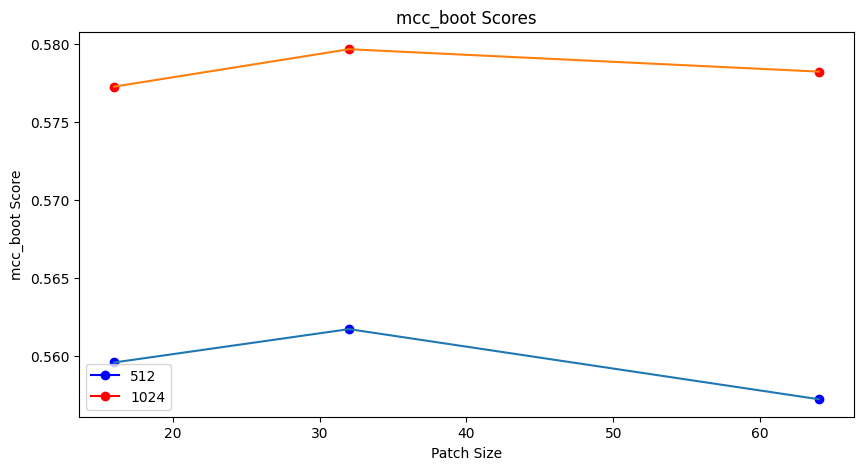

In [24]:
# Plot the results - 
# Each metric will be plotted for each patch size and lookback window
# plot the f1 macro scores
import matplotlib.pyplot as plt
import seaborn as sns

score = 'mcc_boot'

# X Axis will be the patch sizes
patch_sizes = list(results_512.keys())
# remove the p and convert to int
x_labels = [int(patch_size.replace('p', '')) for patch_size in patch_sizes]
# Y axis will be the f1 macro scores
f1_macro_scores = np.array([results_512[patch_size][score].numpy() for patch_size in patch_sizes])
f1_macro_scores_1024 = np.array([results_1024[patch_size][score].numpy() for patch_size in patch_sizes])

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=x_labels, y=f1_macro_scores, ax=ax)
sns.lineplot(x=x_labels, y=f1_macro_scores_1024, ax=ax)
# include points on the plot
ax.scatter(x_labels, f1_macro_scores, color='blue')
ax.scatter(x_labels, f1_macro_scores_1024, color='red')
ax.set_title(f'{score} Scores')
ax.set_xlabel('Patch Size')
ax.set_ylabel(f'{score} Score')
# Set the correct colors in legend by using proxy artists to match scatter colors
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', marker='o', linestyle='-', label='512'),
    Line2D([0], [0], color='red', marker='o', linestyle='-', label='1024')
]
ax.legend(handles=legend_elements)
plt.show()



